# TCR co-occurence clustering

In [1]:
# I run the clustering on the gpu, maybe an environment with these dependencies will take some time to set up. Feel free to ask help.

import cugraph
import cudf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import faiss
import anndata as ad



#my own imports

import aux_graphs as graphs
import seaborn as sns  # Import Seaborn
import pandas as pd



cugraph.__version__

# Hyperparameters
K_NN = 100

/media/pablo/Windows_files/00-master/02 - Semester2/[R1] Research_internship_1/.venv/lib/python3.10/site-packages/cudf/utils/gpu_utils.py:89: UserWarning: A GPU with NVIDIA Volta™ (Compute Capability 7.0) or newer architecture is required.
Detected GPU 0: NVIDIA GeForce GTX 1050                                                                                                                                                                                                                                         
Detected Compute Capability: 6.1
  warnings.warn(


Read in count matrix (AnnData object)

In [2]:
counts = ad.read_h5ad("data/counts_absence_presence_only.h5ad")

#adata is the annotated dataset (no idea the difference in counts and adata)
adata = ad.AnnData(counts)


# show data
display(adata.X)
display(adata.obs)
display(adata.var)

<1413x198944 sparse matrix of type '<class 'numpy.float64'>'
	with 18722800 stored elements in Compressed Sparse Row format>

,Dataset,subject_id,Virus Diseases,Age,Biological Sex,Racial Group,Tissue Source,repertoire_size
sample_name,,,,,,,,
860011283_TCRB,COVID-19-HUniv12Oct,748180,COVID-19 Positive,86 Years,Female,Caucasian,Blood,129743.0
INCOV053-AC-3_TCRB,COVID-19-ISB,053,COVID-19 Positive,86 Years,Male,Caucasian,Blood,86436.0
KH20-09670_TCRB,COVID-19-DLS,550040039,COVID-19 Positive,84 Years,Male,Asian or Pacific Islander,Blood,45859.0
BS-EQ-23-T1-replacement_TCRB,COVID-19-NIH/NIAID,0000142,COVID-19 Positive,49 Years,Male,Caucasian,"Blood,gDNA",57115.0
BS-HS-157_TCRB,COVID-19-NIH/NIAID,NaN,NaN,NaN,NaN,NaN,"Blood,gDNA",23186.0
...,...,...,...,...,...,...,...,...
BS-GIGI_36-replacement_TCRB,COVID-19-NIH/NIAID,0000471,COVID-19 Positive,70 Years,Female,Caucasian,"Blood,gDNA",52262.0
1328-CM-933_TCRB,COVID-19-NIH/NIAID,NaN,NaN,NaN,NaN,NaN,"Buffy Coat,gDNA",106779.0
1566746BW_TCRB,COVID-19-BWNW,1566746,COVID-19 Positive,21 Years,Female,Native American or Alaska Native,Blood,330053.0


,v_call,junction_aa
0,TRBV10-1*01,CASRDSLNTEAFF
1,TRBV10-1*01,CASRDSMNTEAFF
2,TRBV10-1*01,CASRENTGELFF
3,TRBV10-1*01,CASRGQGNTEAFF
4,TRBV10-1*01,CASRGTGELFF
...,...,...
198939,TRBV9*01,CASSVYSGNTIYF
198940,TRBV9*01,CASSVYSTDTQYF
198941,TRBV9*01,CASSVYTDTQYF
198942,TRBV9*01,CASSVYTGELFF


In [3]:
counts[:,[0,1,2]].X.todense()

matrix([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [4]:
#NaN values for each column
adata.obs.isna().sum()

Dataset              0
subject_id         176
Virus Diseases     309
Age                246
Biological Sex     247
Racial Group       268
Tissue Source        0
repertoire_size      0
dtype: int64

In [5]:
#indices de las observaciones
print(adata.obs_names[:3]) #sample names
print(adata.var_names[:10]) #indexes? why dosent this one have a name?

Index(['860011283_TCRB', 'INCOV053-AC-3_TCRB', 'KH20-09670_TCRB'], dtype='object', name='sample_name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')


In [6]:
subset1 = adata[['860011283_TCRB', 'INCOV053-AC-3_TCRB'], ['0','10']]
display(subset1.obs)
display(subset1.var)

,Dataset,subject_id,Virus Diseases,Age,Biological Sex,Racial Group,Tissue Source,repertoire_size
sample_name,,,,,,,,
860011283_TCRB,COVID-19-HUniv12Oct,748180,COVID-19 Positive,86 Years,Female,Caucasian,Blood,129743.0
INCOV053-AC-3_TCRB,COVID-19-ISB,053,COVID-19 Positive,86 Years,Male,Caucasian,Blood,86436.0


,v_call,junction_aa
0,TRBV10-1*01,CASRDSLNTEAFF
10,TRBV10-1*01,CASSAGPNQPQHF


In [7]:
# subset2= adata[adata.obs_names.isin(["860011283_TCRB"]), adata.var_names.isin(["0", "5"])]
subset2 = adata[adata.obs_names.isin(["860011283_TCRB"]), adata.var_names.isin(["0", "10500"])]
display(subset2.obs)
display(subset2.var)

,Dataset,subject_id,Virus Diseases,Age,Biological Sex,Racial Group,Tissue Source,repertoire_size
sample_name,,,,,,,,
860011283_TCRB,COVID-19-HUniv12Oct,748180,COVID-19 Positive,86 Years,Female,Caucasian,Blood,129743.0


,v_call,junction_aa
0,TRBV10-1*01,CASRDSLNTEAFF
10500,TRBV12-1*01,CASSFGQGANYGYTF


In [8]:
subset3 = adata[adata.obs_names.isin(["860011283_TCRB"])]
display(subset3.obs)
display(subset3.var)

,Dataset,subject_id,Virus Diseases,Age,Biological Sex,Racial Group,Tissue Source,repertoire_size
sample_name,,,,,,,,
860011283_TCRB,COVID-19-HUniv12Oct,748180,COVID-19 Positive,86 Years,Female,Caucasian,Blood,129743.0


,v_call,junction_aa
0,TRBV10-1*01,CASRDSLNTEAFF
1,TRBV10-1*01,CASRDSMNTEAFF
2,TRBV10-1*01,CASRENTGELFF
3,TRBV10-1*01,CASRGQGNTEAFF
4,TRBV10-1*01,CASRGTGELFF
...,...,...
198939,TRBV9*01,CASSVYSGNTIYF
198940,TRBV9*01,CASSVYSTDTQYF
198941,TRBV9*01,CASSVYTDTQYF
198942,TRBV9*01,CASSVYTGELFF


In [9]:
metadata = adata.copy()
ct = np.random.choice(["B", "T", "Monocyte"], size=(adata.n_obs,))

metadata.obs["cell type"] = pd.Categorical(ct)
display(metadata.obs)

,Dataset,subject_id,Virus Diseases,Age,Biological Sex,Racial Group,Tissue Source,repertoire_size,cell type
sample_name,,,,,,,,,
860011283_TCRB,COVID-19-HUniv12Oct,748180,COVID-19 Positive,86 Years,Female,Caucasian,Blood,129743.0,T
INCOV053-AC-3_TCRB,COVID-19-ISB,053,COVID-19 Positive,86 Years,Male,Caucasian,Blood,86436.0,T
KH20-09670_TCRB,COVID-19-DLS,550040039,COVID-19 Positive,84 Years,Male,Asian or Pacific Islander,Blood,45859.0,B
BS-EQ-23-T1-replacement_TCRB,COVID-19-NIH/NIAID,0000142,COVID-19 Positive,49 Years,Male,Caucasian,"Blood,gDNA",57115.0,B
BS-HS-157_TCRB,COVID-19-NIH/NIAID,NaN,NaN,NaN,NaN,NaN,"Blood,gDNA",23186.0,T
...,...,...,...,...,...,...,...,...,...
BS-GIGI_36-replacement_TCRB,COVID-19-NIH/NIAID,0000471,COVID-19 Positive,70 Years,Female,Caucasian,"Blood,gDNA",52262.0,B
1328-CM-933_TCRB,COVID-19-NIH/NIAID,NaN,NaN,NaN,NaN,NaN,"Buffy Coat,gDNA",106779.0,T
1566746BW_TCRB,COVID-19-BWNW,1566746,COVID-19 Positive,21 Years,Female,Native American or Alaska Native,Blood,330053.0,B


**FIELD ANALYSIS**

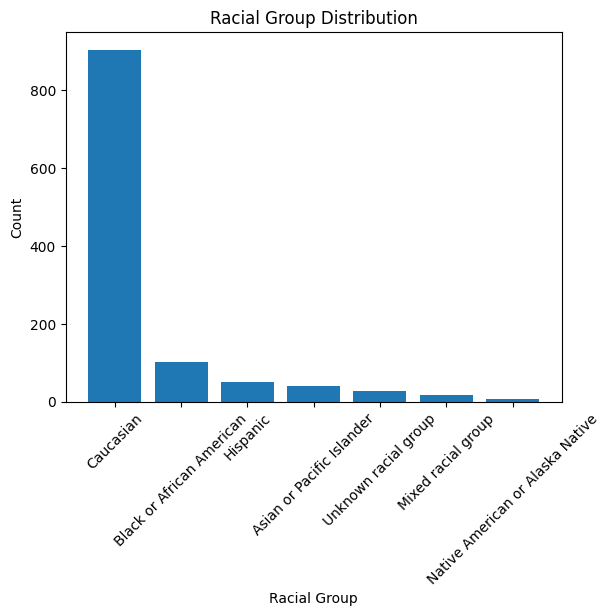

In [10]:
# print(counts.obs["Age"].value_counts())
racial_group_counts = counts.obs["Racial Group"].value_counts()

# Create a bar chart
plt.bar(racial_group_counts.index, racial_group_counts.values)

# Set axis labels and title
plt.xlabel("Racial Group")
plt.ylabel("Count")
plt.title("Racial Group Distribution")

# Rotate x-axis labels for better readability with long labels
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [11]:
#unique age 
print('Unique Age values: {}'.format(adata.obs['Age'].nunique()))
adata.obs['Age'].value_counts()

Unique Age values: 73


89 Years    74
61 Years    48
55 Years    29
56 Years    27
60 Years    27
            ..
21 Years     2
25 Years     2
08 Years     2
20 Years     1
19 Years     1
Name: Age, Length: 73, dtype: int64

In [12]:
print('Unique Sex values: {}'.format(adata.obs['Biological Sex'].nunique()))
adata.obs['Biological Sex'].value_counts()

Unique Sex values: 2


Male      630
Female    536
Name: Biological Sex, dtype: int64

In [ ]:
gpu_resource = faiss.StandardGpuResources()

modify X to change distance metric used

In [3]:
X = counts.X.T.todense()
X = np.ascontiguousarray(X).astype(np.float32)

# X = X/X.sum(axis=0)  # scale the features: fraction instead of counts. Need to experiment with this, does this have an impact? (doesnt really seem to improve things)
# X = normalize(X, norm="l1", axis=0) # test: alternative way of scaling features through L2
# X = X-X.mean(axis=0) # Center the columns to scale features?

X = X-X.mean(axis=1)[:,None]  # Center the rows. Use for adjusted cosine = approx pearson correlation. 
faiss.normalize_L2(X) # L2 normalize counts so that they sum up to one so that cosine similarity is measured (even though we use a dot product index)

KeyboardInterrupt: 

Alternative method: include close neighbors:

In [15]:
# def gaussian(d, sigma):
    # return np.exp(-d**2 / (2 * sigma**2))

# X = np.ascontiguousarray(counts.layers["tcrdist_closest"].T.todense()).astype(np.float32)
# X = np.apply_along_axis(gaussian, 1, X, sigma=6) # distance to similarity
# X = X-X.mean(axis=1)[:,None]  # Center the rows. Use for adjusted cosine = approx pearson correlation. 
# faiss.normalize_L2(X) # L2 normalize counts so that they sum up to one so that cosine similarity is measured (even though we use a dot product index)

In [16]:
import faiss

## K-nearest neighbor graph construction

In [17]:
# construct index
idx = faiss.CpuIndexFlatI(gpu_resource, X.shape[1]) # Inner product index
idx.add(X)

RuntimeError: Error in faiss::gpu::GpuIndex::GpuIndex(std::shared_ptr<faiss::gpu::GpuResources>, int, faiss::MetricType, float, faiss::gpu::GpuIndexConfig) at /project/faiss/faiss/gpu/GpuIndex.cu:53: Error: 'config_.device < getNumDevices()' failed: Invalid GPU device 0

Find the k-NNs for each TCR:

In [ ]:
%%time
D,I = idx.search(X, K_NN) # search. We need to figure out which value of k works best.

In [ ]:
# save result matrices (intermediate step)

np.save("data/D", D)
np.save("data/I", I)

In [ ]:
import numpy as np

# Load the .npy file
D, I = np.load("data/D.npy"), np.load("data/I.npy") # load result matrices if needed

In [ ]:
import pandas as pd
d_df = pd.DataFrame(D)
i_df = pd.DataFrame(I)

display(d_df)
display(i_df)

create k-NN graph:

In [ ]:
D, I = np.load("data/D.npy"), np.load("data/I.npy") # load result matrices if needed

In [ ]:
# D and I matrix to edgelist

edgelist = set()
recursive_edgelist = []

for s,t,sim in zip(
    np.repeat(np.arange(I.shape[0]), K_NN).astype(int), #source
    I[:,:K_NN].ravel(),      #target
    D[:,:K_NN].ravel()):     #distance
        t = int(t)
        if s<t:
            edgelist.add((s,t))
        if t<s:
            if (t,s) in edgelist:
                recursive_edgelist.append((s,t,sim))

del edgelist

In [ ]:
source, target, similarity = zip(*recursive_edgelist)

edge_df = cudf.DataFrame({
    "source":source,
    "target":target,
    "weight":similarity

})

edge_df.source = edge_df.source.astype(np.int32)
edge_df.target = edge_df.target.astype(np.int32)

In [ ]:
G = cugraph.from_cudf_edgelist(edge_df, source="source", destination="target", edge_attr="weight") # create weighted graph object
# G = cugraph.from_cudf_edgelist(edge_df, source="source", destination="target") # create unweighted graph object

In [ ]:
G.is_weighted()

In [ ]:
G.number_of_nodes()

In [ ]:
G.number_of_edges()

In [ ]:
cugraph.connected_components(G)["labels"].nunique()

## Clustering

In [ ]:
scl = cugraph.spectralModularityMaximizationClustering(G, num_clusters=1000, num_eigen_vects=50)
# scl = cugraph.spectralBalancedCutClustering(G, num_clusters=500, num_eigen_vects=50, kmean_tolerance=1E-8, kmean_max_iter=1000)

In [ ]:
scl = scl.to_pandas()

In [ ]:
sizes = scl["cluster"].value_counts().to_numpy()

In [ ]:
fig, ax = plt.subplots(figsize=(5,3),dpi=200)
sns.histplot(sizes)
sns.despine()
ax.set_ylabel("Number of modules")
ax.set_xlabel("Module size")

In [ ]:
counts.var["cluster"] = scl.to_pandas().assign(index=scl["vertex"].astype(str)).set_index("index")["cluster"]

In [ ]:
counts.var["cluster"] = counts.var["cluster"].fillna(-1).astype(int)

In [ ]:
counts.var.to_csv("results/spectral_clustering.csv")
edge_df.to_csv("results/edgelist.csv")